In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector, WavesDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'cpu'})
config.set({'lazy': True})

In [19]:
client = Client()

In [20]:
atoms = bulk('Au', 'diamond', a=5.43, cubic=True)
atoms *= (8, 8, 1)

In [31]:
def a(i):
    return i

def b(i):
    return i

def c(i):
    return i


i = 0
A = dask.delayed(a)(i)
B = dask.delayed(b)(A)
C = dask.delayed(c)(B)

C.compute()


0

In [23]:
%%time
from abtem import show_atoms
from abtem.waves.prism_utils import remove_s_matrix_beam_tilt, prism_wave_vectors, beamlet_weights, interpolate_full, beamlet_basis
from abtem.waves.transfer import CTF
import dask
from abtem.waves import GridScan

frozen_phonons = FrozenPhonons(atoms, 2, {'Au': .2})

potential = Potential(frozen_phonons, 
                      gpts=101,
                      projection='infinite',
                      slice_thickness=1)



s = SMatrix(potential, energy=40e3, planewave_cutoff=20, interpolation=(3,3), chunks=10, partitions=3)

#scan = GridScan(start=(0,0), end=s.extent, sampling=.1)

#scans = scan.divide((3,3))

s = s.build(lazy=True)
s = s.downsample()

s = s._get_s_matrix(0, lazy=False).array

def a(array):
    return array

s = dask.delayed(a)(s)

s = dask.array.from_delayed(s, shape=(10,10), dtype=np.complex64)

#s.visualize(optimize_graph=True)

s.compute()

#s.visualize(optimize_graph=True)
#s.visualize()

#s.array

#s.visualize_graph(optimize_graph=True)
#print(s.array, s.is_cropped)

#s = s.crop_to_positions(scans[0][0])

#s.array


Wall time: 850 ms


array([[[ 0.8374877 +0.5464452j ,  0.97355235+0.07650672j,
          1.0141864 -0.01535308j, ...,  0.9374319 +0.12878478j,
          0.99811274+0.00361642j,  0.8634576 +0.40314692j],
        [ 0.96979076+0.1238666j ,  0.98850435+0.0200209j ,
          0.9369616 +0.16028392j, ...,  1.0284506 -0.0012267j ,
          1.0142269 -0.00636727j,  0.98819   +0.04058925j],
        [ 0.97587997+0.02872135j,  0.9495571 +0.3115608j ,
          0.7886055 +0.728279j  , ...,  0.8434488 +0.43953028j,
          0.85770035+0.44037086j,  1.0499343 -0.06147807j],
        ...,
        [ 0.9915799 +0.02198056j,  1.017389  -0.02466185j,
          0.94173944+0.22266887j, ...,  0.9815952 -0.03336066j,
          0.9641351 +0.06901894j,  0.9989438 -0.03101822j],
        [ 0.9962786 +0.00260737j,  0.9713329 +0.13138346j,
          0.78464514+0.5783955j , ...,  0.97123533+0.06433913j,
          0.92011034+0.51690996j,  0.96018267+0.27224812j],
        [ 0.95329326+0.19606492j,  1.0310969 +0.04187335j,
          0.9

In [5]:
basis = beamlet_basis(ctf, s.wave_vectors, wave_vectors, s.gpts, s.sampling)
parent_s_matrix = s.array

In [104]:
parent_s_matrix.shape, basis.shape

((19, 101, 101), (19, 101, 101))

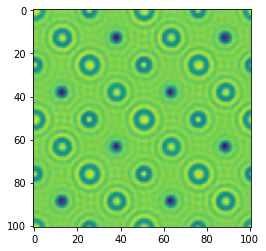

In [6]:
plt.imshow(parent_s_matrix[6].real)

In [174]:
from numba import prange

In [175]:
@nb.jit(nopython=True, nogil=True)
def roll1d_v1(array, shift):
    rolled = np.zeros(array.shape)
    rolled[:shift] = array[-shift:]
    rolled[shift:] = array[:-shift]    
    return rolled

@nb.jit(nopython=True, nogil=True)
def roll1d_v2(array, shift):
    rolled = np.zeros(array.shape)
    for i in prange(array.shape[0]):
        rolled[i] = array[i - shift]
    return rolled

In [211]:
@nb.jit(nopython=True, nogil=True)
def roll2d_v1(array, shift):
    rolled = np.zeros_like(array)
    rolled[:, :shift[0], :shift[1]] = array[:, -shift[0]:, -shift[1]:]
    rolled[:, shift[0]:, :shift[1]] = array[:, :-shift[0], -shift[1]:]
    rolled[:, :shift[0], shift[1]:] = array[:, -shift[0]:, :-shift[1]]
    rolled[:, shift[0]:, shift[1]:] = array[:, :-shift[0], :-shift[1]]
    return rolled

@nb.jit(nopython=True, nogil=True, parallel=True)
def roll1d_v2(array, shift):
    rolled = np.zeros_like(array)
    for i in prange(array.shape[1]):
        for j in prange(array.shape[2]):
            rolled[:, i, j] = array[:, i - shift[0], j - shift[1]]
    return rolled

In [214]:
%%timeit
roll2d_v1(array, (20,20))

6.93 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [217]:
%%timeit
roll1d_v2(array, (20,20))

6.77 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [212]:
from scipy.ndimage import gaussian_filter
array = gaussian_filter(np.random.rand(10, 512,512), 10)



#plt.imshow(array)
#plt.plot(roll1d(array, 10))

#array.dtype

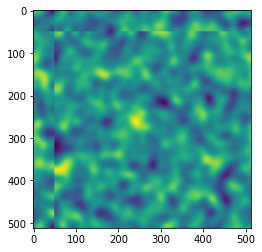

In [204]:
plt.imshow(roll2d_v1(array, (50,50)))

In [33]:
@nb.jit(nopython=True, nogil=True, parallel=True)
def reduce_beamlets_nearest_no_interpolation(waves, basis, parent_s_matrix, shifts):
    assert waves.shape[0] == shifts.shape[0]
    assert basis.shape == parent_s_matrix.shape
    assert waves.shape[1:] == parent_s_matrix.shape[1:]
    
    for i in prange(waves.shape[0]):
        for j in range(waves.shape[1]):
            for k in range(waves.shape[2]):
                waves[i, j, k] = (basis[:, j - shifts[i, 0], k - shifts[i, 1]] * parent_s_matrix[:, j, k]).sum(0)
    return waves

In [34]:
import numba as nb
from abtem.waves.prism import flatten_list_of_lists
from numba import prange

positions = flatten_list_of_lists(scan.get_positions(chunks=100))

#offset = (shape[0] // 2, shape[1] // 2)
#corners = np.rint(np.array(positions) / sampling - offset).astype(np.int)


shifts = np.round(positions[-50].reshape((-1,2)) / s.sampling).astype(int)
waves = np.zeros((len(shifts),) + parent_s_matrix.shape[-2:], dtype=np.complex64)

a = reduce(waves, basis, parent_s_matrix, shifts)

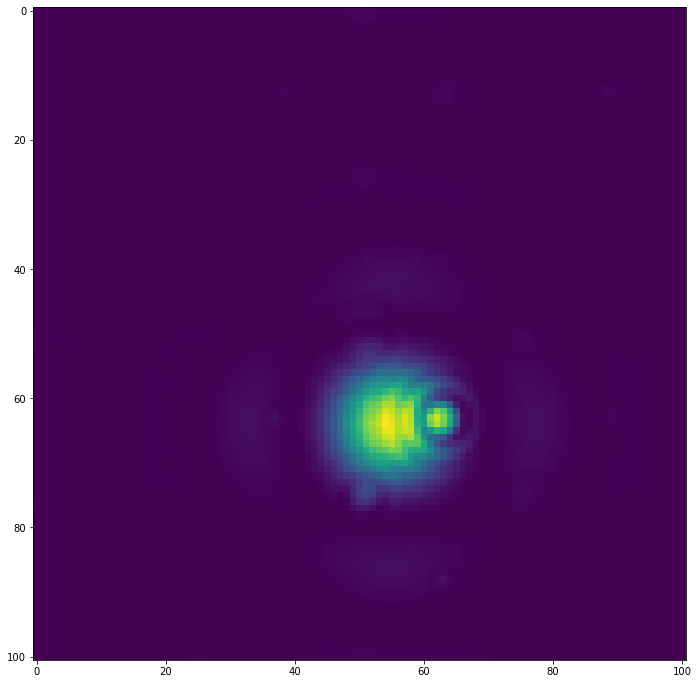

In [35]:
plt.figure(figsize=(12,12))
plt.imshow(np.abs(a[-1])**2)

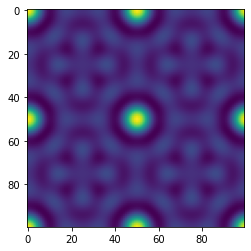

In [522]:
plt.imshow(a.sum(0).real)

In [517]:
subpixel_shift = False

positions = np.array([0,0])

positions = positions / np.array(s.sampling)


if subpixel_shift:
    basis = a * self._fourier_translation_operator(positions)
    basis = np.fft.ifft2(basis, axes=(1, 2))
else:
    positions = np.round(positions).astype(int)
    basis = np.roll(a, positions, axis=(1, 2))

#plt.imshow(np.abs(basis.sum(0)) ** 2)

In [519]:
basis.shape

(37, 100, 100)

In [ ]:
    def get_beamlets(self, positions, subpixel_shift=False):
        xp = get_array_module(positions)
        

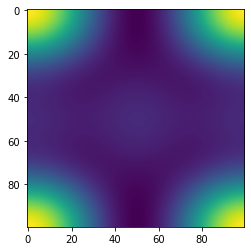

In [493]:
plt.imshow(a.real[0])

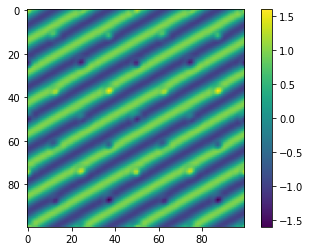

In [458]:
plt.imshow(s1.array[3].real)
plt.colorbar()

In [459]:
%%time
s2 = SMatrix(potential, energy=180e3, planewave_cutoff=20, interpolation=(1,1), chunks=10)

s2 = s2.build(lazy=True).compute()

Wall time: 7.85 s


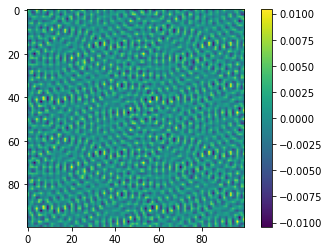

In [474]:
i=105
plt.imshow(s2.array[i].real-s1.array[i].real)
plt.colorbar()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x253ff812280>)

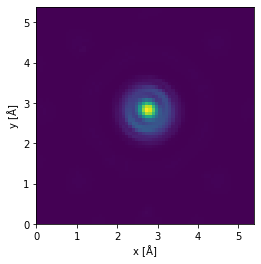

In [23]:
measurement[0].show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x18f2ecb18e0>)

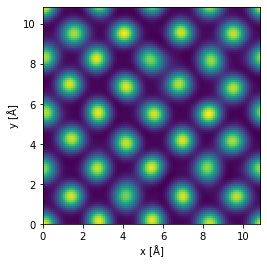

In [29]:
measurement.interpolate(.1).show()

In [32]:
#s.visualize_graph(optimize_graph=True)
s.multislice(potential)#.visualize_graph(optimize_graph=True)

In [2]:
# number of plane waves in each chunk
plane_wave_chunks = 32

# partioning of the griscan. The scattering matrix will be reduced in similarly partitioned chunks. Should be equal to or greater than the interpolation.
scan_partitions = (3, 3)

# Number of positions per reduction operation (single call to np.tensordot), 
# A large value reduces the number of required iterations in Python, but also increases the total number of FLOPS required
positions_per_reduction = 300

# Maximum number of scattering matrices in memory at any point
max_concurrent_s_matrices = 6

frozen_phonons = FrozenPhonons(atoms, 3, {'Si': .0})

potential = Potential(frozen_phonons, 
                      gpts=512,
                      projection='infinite', 
                      slice_thickness=.5)

probe = SMatrix(energy=200e3, semiangle_cutoff=20, chunks=plane_wave_chunks, interpolation=3, max_concurrent=max_concurrent_s_matrices)

scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=True)

probe.grid.match(potential)


measurement = probe.scan(scan, 
                         detectors, 
                         potential,
                         scan_partitions=scan_partitions, 
                         positions_per_reduction=positions_per_reduction)

NameError: name 'atoms' is not defined

In [61]:
probe.build().array # just for showing the scattering matrix size

dask.array<concatenate, shape=(61, 512, 512), dtype=complex64, chunksize=(31, 512, 512), chunktype=numpy.ndarray>

In [62]:
%%time
measurement.compute()

Wall time: 21.2 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x233005c1bb0>)

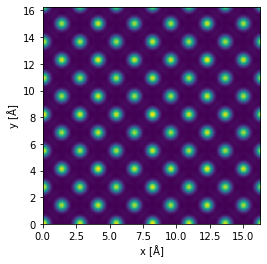

In [63]:
measurement.interpolate(.1).show()